## Predict Cell-cycle Information from Morphodynamic features

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pandas as pd
import sys, os, time, math
import h5py 
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import pickle, subprocess
import umap, scipy, json 
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix,\
precision_score, f1_score, recall_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor 

In [8]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, Dense, Input, Dropout, LeakyReLU, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE, ADASYN

In [9]:
trajl = 1
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = f"{sysName}_{date2day}"

In [10]:
fovs = ['A2_1', 'A2_2', 'A2_3', 'B2_1', 'B2_3', 'B2_4']
nfovs = len(fovs)
pathSet = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/'
modelList = [None]*(nfovs)
modelList_conditions = np.zeros(nfovs).astype(int)

In [11]:
for i in range(nfovs):
    modelList_conditions[i] = i
    modelList[i] = f"{pathSet}{sysName}_{fovs[i]}"
    #print("Model Info: ",modelList[i])

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [12]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print(f"loaded {objFile} with {modelSet[i].cells_indSet.size} cells")
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models, i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1.obj with 51054 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_2.obj with 97764 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_3.obj with 58579 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_1.obj with 67836 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_3.obj with 57884 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_4.obj with 46096 cells


In [13]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [14]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [15]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
for i in indgood_models:
    modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0

In [16]:
n_COMfeatures = 3
Xf_com0 = np.zeros((0, n_COMfeatures))
for i in indgood_models:
    Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [17]:
wctm = cellTraj.Trajectory() # import Trajectory object 
# Cell features: Zernike (49), Haralick (13), Shape (15), Boundary (15) --> total 92
n_features = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, n_features))
indtreatment = np.array([])
indcellSet = np.array([])

for i in indgood_models:
    Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
    # Indices for each model for later access using them
    indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
    indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [18]:
for i in indgood_models:
    indsf = np.where(indtreatment == i)[0]
    modelSet[i].Xf = Xf[indsf, :]

In [19]:
self = wctm
all_trajSet = [None]*nmodels
for i in indgood_models:
    print(f"Get single-cell trajectories of model: {i}")
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

Get single-cell trajectories of model: 0
tracked cell 50891, 25 tracks, 46600 left
tracked cell 50763, 23 tracks, 42400 left
tracked cell 50735, 51 tracks, 41500 left
tracked cell 50076, 1 tracks, 37700 left
tracked cell 49741, 1 tracks, 37600 left
tracked cell 49307, 1 tracks, 37500 left
tracked cell 49056, 18 tracks, 37400 left
tracked cell 48763, 1 tracks, 37100 left
tracked cell 48214, 1 tracks, 36900 left
tracked cell 48008, 1 tracks, 36800 left
tracked cell 47562, 1 tracks, 36500 left
tracked cell 46286, 1 tracks, 35900 left
tracked cell 46119, 3 tracks, 35700 left
tracked cell 45624, 1 tracks, 35600 left
tracked cell 42924, 7 tracks, 34200 left
tracked cell 41889, 2 tracks, 33800 left
tracked cell 41728, 1 tracks, 33700 left
tracked cell 40948, 1 tracks, 33300 left
tracked cell 39770, 1 tracks, 32900 left
tracked cell 39018, 1 tracks, 32500 left
tracked cell 38257, 1 tracks, 32300 left
tracked cell 38063, 6 tracks, 32200 left
tracked cell 37504, 1 tracks, 32000 left
tracked cell

## Load Cell Features & Labels Extracted from O2VAE (https://github.com/directysj/o2vae.git)

In [20]:
latent_dim=256 # Latent (Bottleneck) Dimension of Variational Auto-encoder 
for i in indgood_models:
    data_vae = np.load(f'../o2vae/features_vae{latent_dim}_{sysName[:-1]}{fovs[i]}.npz')
    features_vae = data_vae['embeddings']
    #labels_vae = data_vae['labels']
    modelSet[i].Xf_vae = features_vae
    #cell2cell_interaction_features = modelSet[i].Xf[:, 77:]
    #modelSet[i].Xf_new = np.concatenate((modelSet[i].Xf_vae, cell2cell_interaction_features), axis=1)

In [21]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

## Single-cell Trajectories Over The Cell Features

In [22]:
trajectory_lengths = np.array([1, 4, 8, 20, 40])

In [23]:
trajl = trajectory_lengths[0]
Xf_traj = np.zeros((0, modelSet[0].Xf_vae.shape[1]*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
for i in indgood_models:
    print(f'Building trajectory data for model: {i}')
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    data = modelSet[i].Xf_vae[modelSet[i].traj, :] 
    #data = modelSet[i].Xf_new[modelSet[i].traj, :]
    #datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_vae.shape[1]*trajl)
    #data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_new.shape[1]*trajl)
    #datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    #data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xf_traj = np.append(Xf_traj, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    ind_frames = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame indices at the start of snippets
    ind_frames = ind_frames + trajl # Frame indices at the end of snippets
    indframes_traj = np.append(indframes_traj, ind_frames) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories

Building trajectory data for model: 0
Building trajectory data for model: 1
Building trajectory data for model: 2
Building trajectory data for model: 3
Building trajectory data for model: 4
Building trajectory data for model: 5


In [24]:
def get_cellCycInfoTrajs(file_info):
    with open(file_info, 'r') as fp:
        lines = fp.readlines()

    nuc2cytoRatio = []
    CC_vals = []
    frames = []

    for line1, line2, line3 in zip(lines[::3], lines[1::3], lines[2::3]):
        line1 = np.array(line1.strip()[1:-1].split(', '), dtype=float)
        line2 = np.array(line2.strip()[1:-1].split(', '), dtype=float)
        line3 = np.array(line3.strip()[1:-1].split(', '), dtype=int)

        mask = ~np.isnan(line1)
        line1 = line1[mask]
        line2 = line2[mask]
        line3 = line3[mask]

        nuc2cytoRatio.append(line1)
        CC_vals.append(line2)
        frames.append(line3)

    return nuc2cytoRatio, CC_vals, frames

In [25]:
file_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/cellCycInfoRawReporterImgs/'
sname_reporter = "LI204601_G"

## Get Nuc/Cyto Ratios and CC values along all single-cell trajectories  

In [26]:
X = [None] * nfovs
y = [None] * nfovs

for i in range(nfovs):
    # Get cross-correlation values along all single-cell trajectories  
    cc_filename = f"{file_path}{sname_reporter}_{fovs[i]}.dat"
    n2c_ratio, cc_vals, frame_numbers = get_cellCycInfoTrajs(cc_filename)

    valid_indstm = []
    nuc2Cyto_ratio_last_frames = []
    model_indc = i
    indstm = np.where(indtreatment_traj == model_indc)[0]
    fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
    indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 
    
    for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
        # Look for a snippet frame within its full trajectory
        possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_snippets[j])[0]
        if len(possible_indices) > 0:
            nbc_ratio = n2c_ratio[ind_fulltraj][possible_indices[0]]
            nuc2Cyto_ratio_last_frames.append(nbc_ratio)
            valid_indstm.append(indstm[j]) 
         
    nuc2Cyto_ratio_last_frames = np.array(nuc2Cyto_ratio_last_frames)
    X[i] = Xf_traj[valid_indstm]  # Use the valid indices to index into Xf_traj
    y[i] = nuc2Cyto_ratio_last_frames
    print(f"Preparing data of {fovs[i]} field of view.")

Preparing data of A2_1 field of view.
Preparing data of A2_2 field of view.
Preparing data of A2_3 field of view.
Preparing data of B2_1 field of view.
Preparing data of B2_3 field of view.
Preparing data of B2_4 field of view.


In [27]:
def trim_cc_vals(ratio_values, num_bins, target_density):
    df = pd.DataFrame(ratio_values, columns=['CC'])
    df['original_index'] = df.index # Include original indices in the DataFrame
    
    counts, bin_edges = np.histogram(df['CC'], bins=num_bins) # Calculate histogram without plotting
    df['bin'] = pd.cut(df['CC'], bins=bin_edges, labels=False, include_lowest=True) # Create a bin label based on the bin_edges

    trimmed_data = []
    
    for i in range(num_bins):
        bin_filter = (df['bin'] == i) # Filter the DataFrame to get data only in this bin
        bin_data = df[bin_filter]

        # If the number of items in the bin is greater than target_density, sample down
        if bin_data.shape[0] > target_density:
           sampled_data = bin_data.sample(n=target_density, random_state=42)
        else:
           sampled_data = bin_data
        trimmed_data.append(sampled_data) # Append the sampled or full bin data to the list
    
    trimmed_df = pd.concat(trimmed_data) # Concatenate all trimmed data back into a DataFrame
    trimmed_df = trimmed_df.sort_values('original_index') # Sorting by original index to preserve the original data order
    
    return trimmed_df

## Split Data in Training & Test Sets

In [28]:
scaler_nn = MinMaxScaler() # Scale features in the range [0, 1]

fovs_indc = [i for i in range(nfovs)]
fovs_indc = np.array(fovs_indc)
fovs_inds_test = np.array([3, 4, 5])
train_fovs = np.setdiff1d(fovs_indc, fovs_inds_test)

X_train = np.zeros((0, X[0].shape[1]))
y_train = np.zeros(0)
for it_fov in train_fovs:
    X_train = np.append(X_train, X[it_fov], axis = 0)
    y_train = np.append(y_train, y[it_fov], axis = 0) # Nuc/Cyto Ratio

target_density = 2000; n_bins = 50 
############################ Trim Training Data ############################ 
trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
original_indices_train = []
y_train_trim = []
    
for it in range(trimmed_cc_train['original_index'].shape[0]):
    original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
    y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
original_indices_train = np.array(original_indices_train)
y_train_trim = np.array(y_train_trim)
X_train_trim = X_train[original_indices_train, :]

######### Scale All Features in the Same Range #########
X_train_nn = scaler_nn.fit_transform(X_train_trim)

#for i, fov in enumerate(fovs_inds_test):
    #test_fov = fov
test_fov = 5
X_test = X[test_fov]
y_test = y[test_fov]
X_test_nn = scaler_nn.transform(X_test)

## Visualize Training & Test Sets Data

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

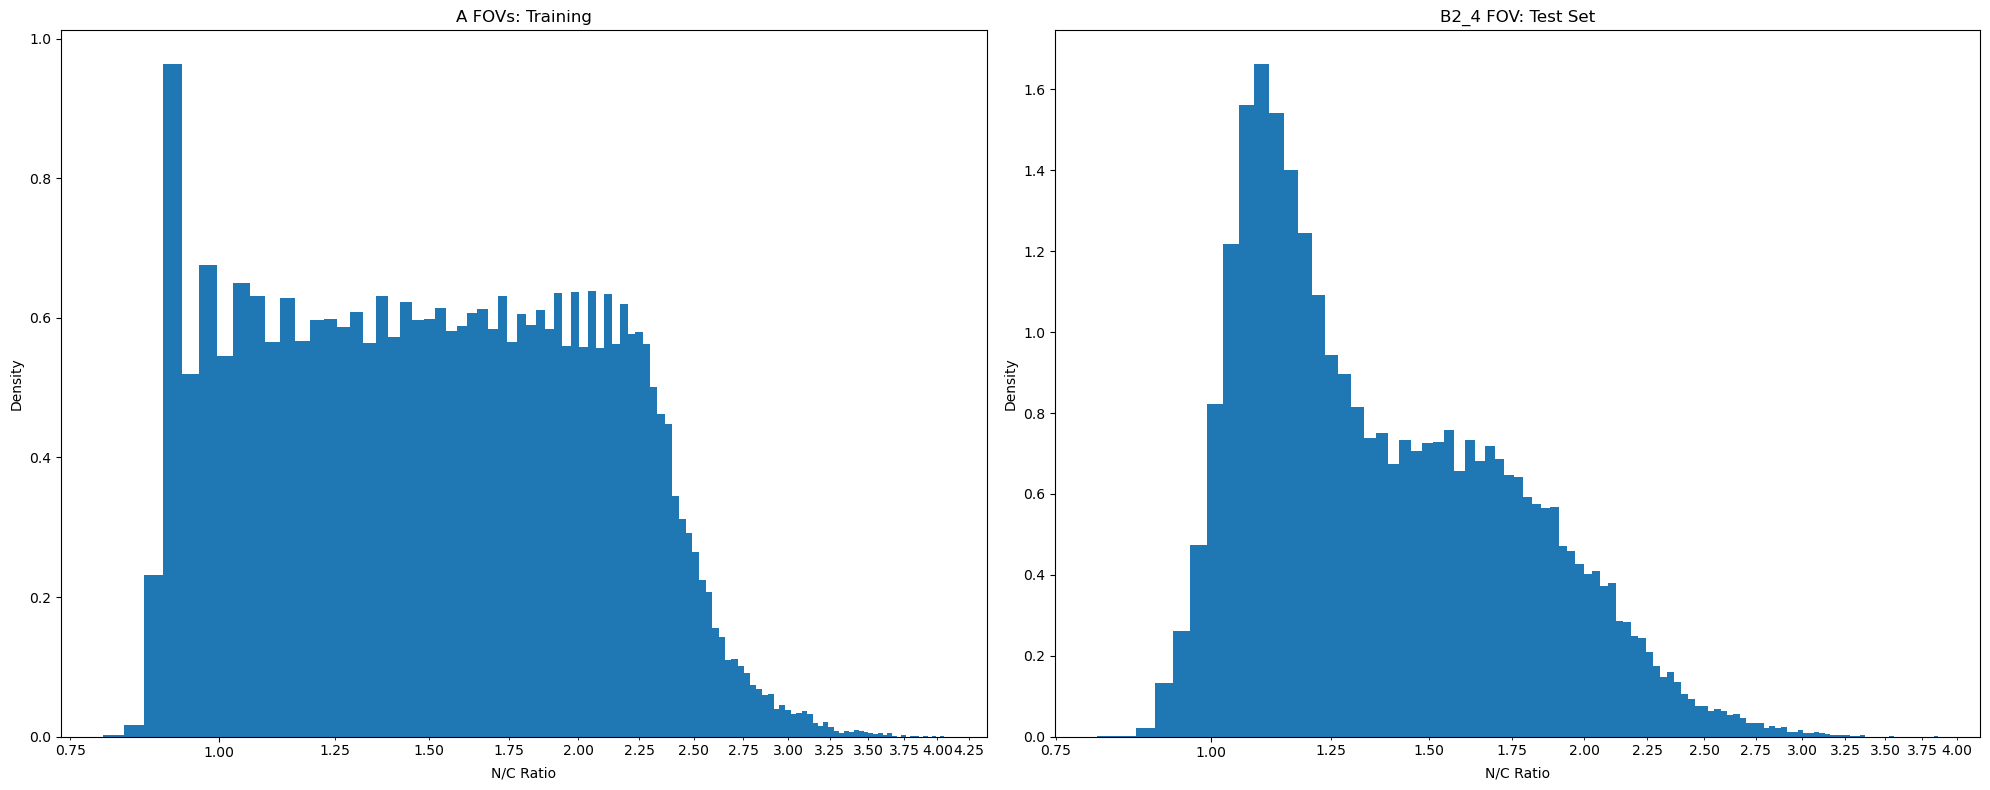

In [29]:
plt.clf()
fig, axs = plt.subplots(1, 2, figsize = (20, 8))
axs = axs.flatten()

formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)

axs[0].hist(y_train_trim, bins=100, density=True)
axs[0].set_xscale('log')
axs[0].set_xlabel('N/C Ratio')
axs[0].set_ylabel('Density')
axs[0].set_title('A FOVs: Training')
axs[0].xaxis.set_major_formatter(formatter)
axs[0].xaxis.set_minor_formatter(formatter)
axs[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.25))

axs[1].hist(y_test, bins=100, density=True)
axs[1].set_xscale('log')
axs[1].set_xlabel('N/C Ratio')
axs[1].set_ylabel('Density')
axs[1].set_title(f'{fovs[test_fov]} FOV: Test Set')
axs[1].xaxis.set_major_formatter(formatter)
axs[1].xaxis.set_minor_formatter(formatter)
axs[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
plt.tight_layout()
#plt.savefig(f"./figs/distN2Cratio_{fovs[test_fov]}_trajl{trajl}_VAE{latent_dim}.png", dpi=400, bbox_inches='tight')
plt.show

## Define Classes (Semi-supervised) in Data before Classification/Regression

In [30]:
def class_conditions(data, class_boundaries):
    conditions = []
    for i, (lower, upper) in enumerate(class_boundaries):
        if np.isinf(upper):
            condition = (data >= lower)
        else:
            condition = (data >= lower) & (data < upper)
        conditions.append(condition)
    return conditions

def multiclass_classification(X_train, X_test, data_train, data_test, class_boundaries):
    class_labels = list(range(len(class_boundaries)))
    
    train_conditions = class_conditions(data_train, class_boundaries)
    test_conditions = class_conditions(data_test, class_boundaries)
    
    # Filter data and labels
    y_train_class = np.select(train_conditions, class_labels, default=-1)  # -1 for data outside boundaries
    y_test_class = np.select(test_conditions, class_labels, default=-1)
    
    # Remove data outside boundaries and their indices
    valid_train_idx = y_train_class != -1
    valid_test_idx = y_test_class != -1
    # Filter Data as per class definitions 
    X_train_fil = X_train[valid_train_idx]
    X_test_fil = X_test[valid_test_idx]
    y_train_fil = data_train[valid_train_idx]
    y_test_fil = data_test[valid_test_idx]
    y_train_class = y_train_class[valid_train_idx]
    y_test_class = y_test_class[valid_test_idx]
    
    y_train_class_onehot = to_categorical(y_train_class)
    y_test_class_onehot = to_categorical(y_test_class)
    
    return X_train_fil, X_test_fil, y_train_fil, y_test_fil, y_train_class, y_test_class, y_train_class_onehot, y_test_class_onehot

In [31]:
#class_boundaries = [(0, 0.95), (1.0, 1.3), (1.5, 2.25), (2.5, np.inf)]  # For 4 classes: Nuc/Cyto Ratio Ranges
class_boundaries = [(0.0, 0.9), (0.9, 2.7), (2.7, np.inf)]# For 3 classes: Nuc/Cyto Ratio Ranges
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered,\
y_train_class, y_test_class, y_train_class_onehot, y_test_class_onehot = multiclass_classification(X_train_nn,
                                                                                                   X_test_nn,
                                                                                                   y_train_trim,
                                                                                                   y_test, 
                                                                                                   class_boundaries)
num_classes = len(class_boundaries)

## Convolutional & Deep Neural Network Model Architecture

In [32]:
def create_model(input_shape, num_classes):
    
    inputs = Input(shape=input_shape) # Define the input layer
    x = Reshape((input_shape[0], 1, 1))(inputs) # Reshape input to fit Conv2D layer requirements

    ############################### First CNN layer #################################
    x = Conv2D(32, kernel_size=(3, 1), padding='same', kernel_regularizer=l2(0.01))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    x = Dropout(0.2)(x)

    ############################### Second CNN layer ################################
    x = Conv2D(64, kernel_size=(3, 1), padding='same', kernel_regularizer=l1(0.02))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x) # Flatten output of the last CNN layer

    ############################## First Dense layer ################################
    x = Dense(128, kernel_regularizer=l2(0.01))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    ############################# Second Dense layer ################################
    x = Dense(64, kernel_regularizer=l1(0.02))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x) # Output layer
    #######################@ Define model using "Model" API @########################
    model = Model(inputs=inputs, outputs=outputs) 
    
    return model

In [33]:
input_shape = (X_train_filtered.shape[1], ) # Define input shape
# Create a Neural Network Model using the "Model" API from KERAS
model_nn = create_model(input_shape, num_classes) 

## Compile the model & Add early stopping to overcome potential overfitting 

In [34]:
model_nn.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', 
                               restore_best_weights=True,
                               patience=15,
                               min_delta=0.001) 

## Calculate class weights

## Oversample the minority class

In [35]:
over_sampler = RandomOverSampler(random_state=42, sampling_strategy='not majority')
#over_sampler = KMeansSMOTE(random_state=42, sampling_strategy='not majority')
#over_sampler = ADASYN(random_state=42, sampling_strategy='not majority')
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train_filtered, y_train_class)

In [36]:
# Train the model with oversampling
history_nn = model_nn.fit(X_train_resampled,
                          to_categorical(y_train_resampled),
                          epochs=50,
                          batch_size=20, 
                          validation_split=0.2,
                          callbacks=[early_stopping])

Epoch 1/50
5920/5920 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - accuracy: 0.6613 - loss: 3.2724 - val_accuracy: 0.0022 - val_loss: 1.7987
Epoch 2/50
5920/5920 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - accuracy: 0.6788 - loss: 0.8003 - val_accuracy: 0.4449 - val_loss: 1.0112
Epoch 3/50
5920/5920 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.6811 - loss: 0.7897 - val_accuracy: 0.6763 - val_loss: 0.8415
Epoch 4/50
5920/5920 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.6812 - loss: 0.7855 - val_accuracy: 0.0431 - val_loss: 1.4335
Epoch 5/50
5920/5920 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.6790 - loss: 0.7808 - val_accuracy: 0.1984 - val_loss: 1.3093
Epoch 6/50
5920/5920 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.6769 - loss: 0.7870 - val_accuracy: 0.1834 - val_loss: 1.3822
Epoch 7/50
5920/5920 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.6842 - loss: 0.7771 - val_accuracy: 0.5405 - val_loss: 0.9307
Epoch 8/50
5920/5920 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.6845 - loss: 0

## Predict on the test set

In [37]:
y_pred_nn = model_nn.predict(X_test_filtered) # Predictions on the Test Set using CNN(2)+DNN(2) Model
predicted_classes = np.argmax(y_pred_nn, axis=1) # Get the predicted classes

1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


## Calculate the prediction metrics

In [38]:
accuracy = accuracy_score(y_test_class, predicted_classes)
precision = precision_score(y_test_class, predicted_classes, average="weighted", zero_division=np.nan)
recall = recall_score(y_test_class, predicted_classes, average="weighted")
f1 = f1_score(y_test_class, predicted_classes, average="weighted")

print(f"Accuracy: {accuracy * 100:.3f}%, Precision: {precision * 100:.3f}%, Recall: {recall * 100:.3f}%, F1-score: {f1 * 100:.3f}%")
"""
performance_data = {
    "Accuracy": f"{accuracy * 100:.3f}%",
    "Precision": f"{precision * 100:.3f}%",
    "Recall": f"{recall * 100:.3f}%",
    "F1-score": f"{f1 * 100:.3f}%"
}
with open(f"./jsonFiles/performanceNN_{fovs[test_fov]}_trajl{trajl}_VAE{latent_dim}Cls{num_classes}.json", 'w') as fout:
    json.dump(performance_data, fout, indent=4)
"""

Accuracy: 40.691%, Precision: 98.467%, Recall: 40.691%, F1-score: 56.947%


'\nperformance_data = {\n    "Accuracy": f"{accuracy * 100:.3f}%",\n    "Precision": f"{precision * 100:.3f}%",\n    "Recall": f"{recall * 100:.3f}%",\n    "F1-score": f"{f1 * 100:.3f}%"\n}\nwith open(f"./jsonFiles/performanceNN_{fovs[test_fov]}_trajl{trajl}_VAE{latent_dim}Cls{num_classes}.json", \'w\') as fout:\n    json.dump(performance_data, fout, indent=4)\n'

## Calculate and Visualize Confusion Matrix

In [39]:
class_labels = [i for i in range(num_classes)]
conf_matrix = confusion_matrix(y_test_class, predicted_classes, labels=class_labels, normalize='true')

<Figure size 640x480 with 0 Axes>

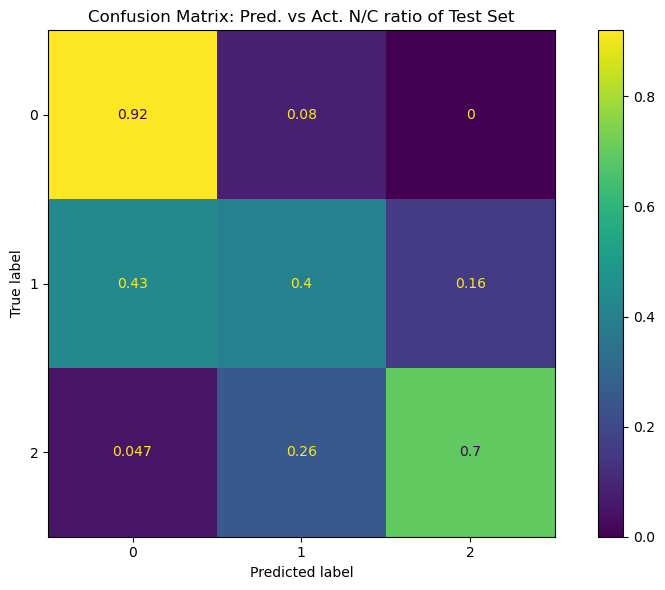

In [40]:
plt.clf()
fig, axs = plt.subplots(figsize=(9, 6))
disp_cm = ConfusionMatrixDisplay(conf_matrix)
disp_cm.plot(ax=axs)
plt.title('Confusion Matrix: Pred. vs Act. N/C ratio of Test Set')
plt.tight_layout()
#plt.savefig(f"./figs/confMatrixNN_{fovs[test_fov]}_trajl{trajl}_VAE{latent_dim}Cls{num_classes}.png", dpi=400, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

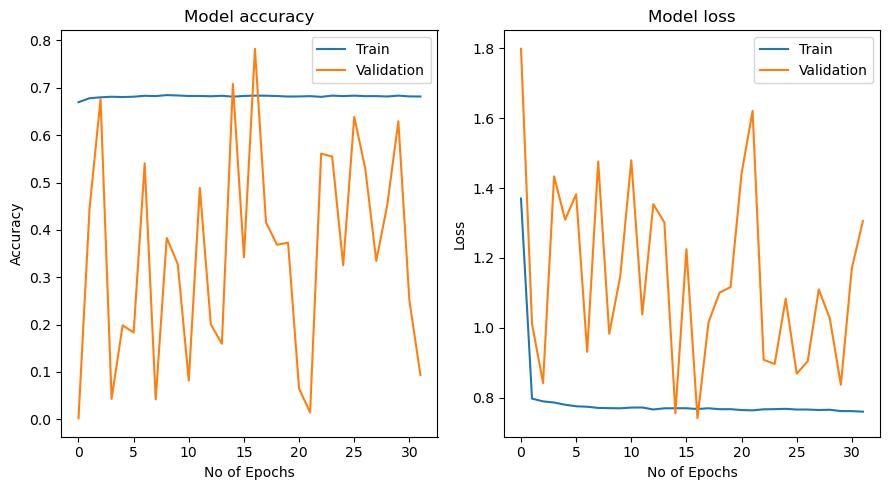

In [41]:
plt.clf()
plt.figure(figsize = (9, 5))
plt.subplot(1, 2, 1)
plt.plot(history_nn.history['accuracy'])
plt.plot(history_nn.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history_nn.history['loss'])
plt.plot(history_nn.history['val_loss'])
plt.title('Model loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
#plt.savefig(f"./figs/performanceNN_{fovs[test_fov]}_trajl{trajl}_VAE{latent_dim}Cls{num_classes}.png", dpi=400, bbox_inches='tight')
plt.show()

## Infer Predictions of Dependent Variable from the Predicted Probabilities of Classes

In [42]:
# Append Class Probabilities from the Neural Network Classifier to VAE Features
X_test_predProb_nn = np.concatenate((X_test_filtered, y_pred_nn), axis=1)

In [43]:
def create_regression_model_nn(input_shape):
    
    inputs = Input(shape=input_shape) # Define the input layer
    x = Reshape((input_shape[0], 1, 1))(inputs) # Reshape input to fit Conv2D layer requirements

    ############################### First CNN layer #################################
    x = Conv2D(32, kernel_size=(3, 1), padding='same', kernel_regularizer=l2(0.01))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    x = Dropout(0.2)(x)

    ############################### Second CNN layer ################################
    x = Conv2D(64, kernel_size=(3, 1), padding='same', kernel_regularizer=l1(0.02))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x) # Flatten output of the last CNN layer

    ############################## First Dense layer ################################
    x = Dense(128, kernel_regularizer=l2(0.01))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    ############################# Second Dense layer ################################
    x = Dense(64, kernel_regularizer=l1(0.02))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    outputs = Dense(1, activation='relu')(x) # Output layer
    #######################@ Define model using "Model" API @########################
    model = Model(inputs=inputs, outputs=outputs) 
    
    return model

In [44]:
input_shape = (X_test_predProb_nn.shape[1], ) # Define input shape
# Create a Neural Network Regression Model using the "Model" API from KERAS
regression_model_nn = create_regression_model_nn(input_shape) 

In [58]:
regression_model_nn.compile(optimizer=Adam(learning_rate=0.001),
                            loss='msle',
                            metrics=['mae', 'r2_score'])

early_stopping = EarlyStopping(monitor='val_loss', 
                               restore_best_weights=True,
                               patience=15,
                               min_delta=0.0001)

In [59]:
# Train the regression model
history_nn_reg = regression_model_nn.fit(X_test_predProb_nn,
                                         y_test_filtered,
                                         epochs=50,
                                         batch_size=20, 
                                         validation_split=0.2,
                                         callbacks=[early_stopping])

Epoch 1/50
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0613 - mae: 0.3030 - r2_score: 0.1823 - val_loss: 0.0584 - val_mae: 0.2988 - val_r2_score: 0.1107
Epoch 2/50
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0565 - mae: 0.2993 - r2_score: 0.1985 - val_loss: 0.0590 - val_mae: 0.3070 - val_r2_score: 0.1003
Epoch 3/50
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0561 - mae: 0.2989 - r2_score: 0.1928 - val_loss: 0.0577 - val_mae: 0.3011 - val_r2_score: 0.1295
Epoch 4/50
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0561 - mae: 0.2948 - r2_score: 0.2187 - val_loss: 0.0597 - val_mae: 0.2984 - val_r2_score: 0.0970
Epoch 5/50
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0565 - mae: 0.2966 - r2_score: 0.2148 - val_loss: 0.0584 - val_mae: 0.3019 - val_r2_score: 0.1276
Epoch 6/50
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0561 - mae: 0.3000 - r2_score: 0.1976 - val_loss: 0.0581 - val_mae: 0.3049 - val_r2_score: 0.0422
Epoch 7/50
1584/1584 ━

In [60]:
y_pred_nn_reg = regression_model_nn.predict(X_test_predProb_nn) # Predictions on the Test Set using CNN(2)+DNN(2) Model

1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


<Figure size 640x480 with 0 Axes>

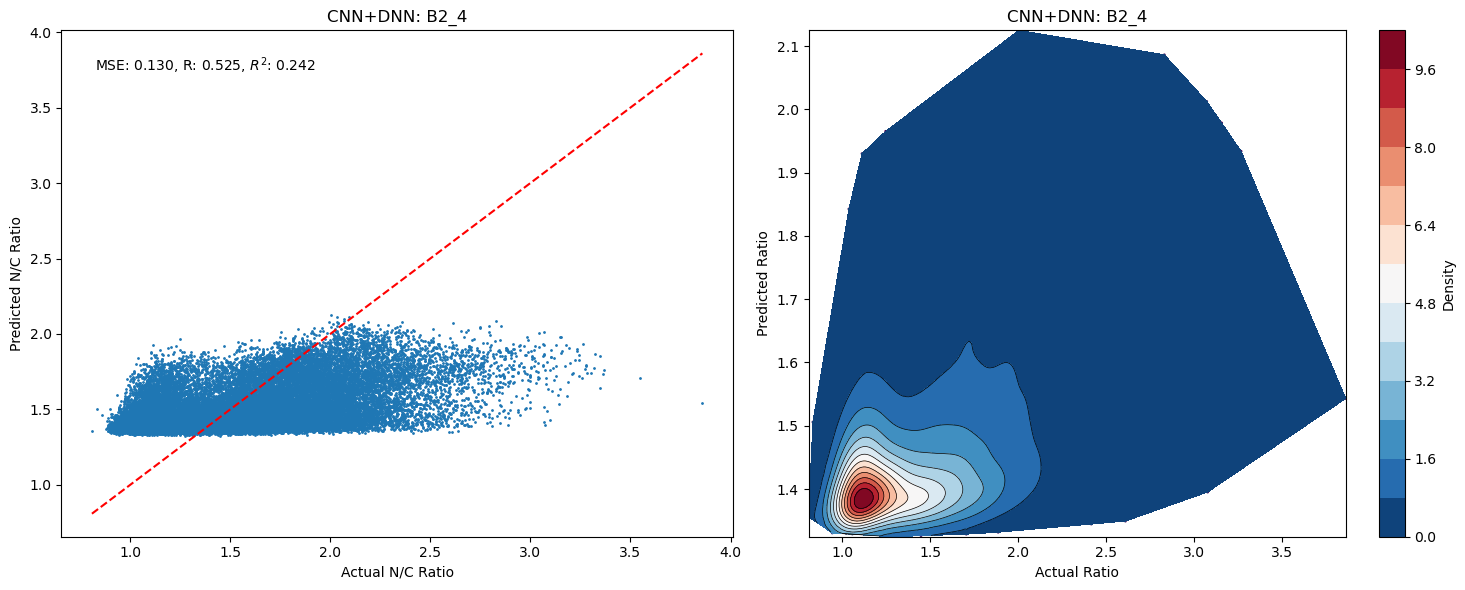

In [61]:
y_pred_nn_reg = y_pred_nn_reg.flatten()
mse_test_reg = mean_squared_error(y_test_filtered, y_pred_nn_reg) # Mean-Squared Error
R2_test_reg = r2_score(y_test_filtered, y_pred_nn_reg) # R^2
R_test_reg = np.corrcoef(y_test_filtered, y_pred_nn_reg)[0, 1] # Pearson's R: Correlation Coefficient 

plt.clf()
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].scatter(y_test_filtered, y_pred_nn_reg, s=1)
axs[0].plot([y_test_filtered.min(), y_test_filtered.max()], [y_test_filtered.min(), y_test_filtered.max()], 'r--') # Best fit line 
axs[0].set_xlabel('Actual N/C Ratio')
axs[0].set_ylabel('Predicted N/C Ratio')
axs[0].set_title(f'CNN+DNN: {fovs[test_fov]}')
axs[0].text(0.05, 0.95, f'MSE: {mse_test_reg:.3f}, R: {R_test_reg:.3f}, $R^2$: {R2_test_reg:.3f}', 
            transform=axs[0].transAxes,
            verticalalignment='top',
            horizontalalignment='left')

############ KDE + Contour Plot ############
xy = np.vstack([y_test_filtered, y_pred_nn_reg])
z = scipy.stats.gaussian_kde(xy)(xy)
    
sc = axs[1].scatter(y_test_filtered, y_pred_nn_reg, c=z, s=1, label='Data Points')
axs[1].tricontour(y_test_filtered, y_pred_nn_reg, z, levels=14, linewidths=0.5, colors='k')
contour_plot = axs[1].tricontourf(y_test_filtered, y_pred_nn_reg, z, levels=14, cmap="RdBu_r")
fig.colorbar(contour_plot, ax=axs[1], label='Density')
axs[1].set_xlabel('Actual Ratio')
axs[1].set_ylabel('Predicted Ratio')
axs[1].set_title(f'CNN+DNN: {fovs[test_fov]}')
plt.tight_layout()
#plt.savefig(f"./figs/ratioN2C_LassoNN_{fovs[test_fov]}_trajl{trajl}_VAE{latent_dim}Cls{num_classes}.png", dpi=400, bbox_inches='tight')
plt.show()